<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Create-network" data-toc-modified-id="Create-network-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Create network</a></span></li><li><span><a href="#Train-Network" data-toc-modified-id="Train-Network-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train Network</a></span></li><li><span><a href="#Latent-representation" data-toc-modified-id="Latent-representation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Latent representation</a></span><ul class="toc-item"><li><span><a href="#Extract-latent-data" data-toc-modified-id="Extract-latent-data-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Extract latent data</a></span></li><li><span><a href="#Visualize-latent-data" data-toc-modified-id="Visualize-latent-data-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Visualize latent data</a></span></li></ul></li><li><span><a href="#Classification" data-toc-modified-id="Classification-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Classification</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Logistic-Regression-Evaluation" data-toc-modified-id="Logistic-Regression-Evaluation-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Logistic Regression Evaluation</a></span></li><li><span><a href="#Support-Vector-Machine" data-toc-modified-id="Support-Vector-Machine-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Support Vector Machine</a></span></li><li><span><a href="#Support-Vector-Machine-Evaluation" data-toc-modified-id="Support-Vector-Machine-Evaluation-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Support Vector Machine Evaluation</a></span></li></ul></li></ul></div>

# Autoencoder
https://www.kaggle.com/shivamb/how-autoencoders-work-intro-and-usecases

When using Autoencoder there is no need for dealing with the imbalance in the dataset since the training happens on the majority class only. Maybe for CV or testing this is relevant again?!

## Data

In [2]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=2)

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

seed=42

In [3]:
data = pd.read_csv("../data/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
X = data.drop('Class', axis=1)
y = data.Class

X_sca_MM = MinMaxScaler().fit_transform(X.values)
X_sca_R = RobustScaler().fit_transform(X.values)
X_sca_Std = StandardScaler().fit_transform(X.values)

In [5]:
X_inp = X_sca_Std          # switch between different scaling methods

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_inp, y, test_size=0.3,
                                              random_state=seed, stratify=y)

## Create network

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers

print(tf.__version__)

2.0.0


In [8]:
input_dim = X.shape[1]

## input layer 
input_layer = Input(shape=(input_dim,)) # num_features

## encoding part
encoded = Dense(500, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(250, activation='relu')(encoded)
encoded = Dense(5, activation='relu')(encoded)

## decoding part
decoded = Dense(10, activation='tanh')(encoded)
decoded = Dense(20, activation='tanh')(decoded)

## output layer
output_layer = Dense(input_dim, activation='relu')(decoded)

In [9]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(learning_rate=0.005,
                    optimizer="adadelta", loss="mse")

In [10]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 500)               15500     
_________________________________________________________________
dense_1 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1255      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_4 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630   

## Train Network

In [11]:
num_train_samples = 50000

In [12]:
X_norm, X_fraud = X_train[y_train == 0], X_train[y_train == 1]

In [13]:
autoencoder.fit(X_norm[:num_train_samples], X_norm[:num_train_samples], 
                batch_size=64, epochs=100, 
                shuffle=True, validation_split=0.20);

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 11s 280us/sample - loss: 0.9976 - val_loss: 0.9940
Epoch 2/100
40000/40000 [==============================] - 6s 162us/sample - loss: 0.9921 - val_loss: 0.9892
Epoch 3/100
40000/40000 [==============================] - 6s 158us/sample - loss: 0.9877 - val_loss: 0.9853
Epoch 4/100
40000/40000 [==============================] - 6s 157us/sample - loss: 0.9841 - val_loss: 0.9822
Epoch 5/100
40000/40000 [==============================] - 7s 165us/sample - loss: 0.9811 - val_loss: 0.9796
Epoch 6/100
40000/40000 [==============================] - 11s 264us/sample - loss: 0.9786 - val_loss: 0.9774
Epoch 7/100
40000/40000 [==============================] - 11s 273us/sample - loss: 0.9764 - val_loss: 0.9755
Epoch 8/100
40000/40000 [==============================] - 7s 187us/sample - loss: 0.9745 - val_loss: 0.9737
Epoch 9/100
40000/40000 [==============================] - 7s 177us/sample 

40000/40000 [==============================] - 7s 181us/sample - loss: 0.9269 - val_loss: 0.9282
Epoch 75/100
40000/40000 [==============================] - 9s 216us/sample - loss: 0.9265 - val_loss: 0.9278
Epoch 76/100
40000/40000 [==============================] - 7s 182us/sample - loss: 0.9261 - val_loss: 0.9275
Epoch 77/100
40000/40000 [==============================] - 8s 211us/sample - loss: 0.9257 - val_loss: 0.9271
Epoch 78/100
40000/40000 [==============================] - 8s 199us/sample - loss: 0.9253 - val_loss: 0.9267
Epoch 79/100
40000/40000 [==============================] - 9s 229us/sample - loss: 0.9250 - val_loss: 0.9263
Epoch 80/100
40000/40000 [==============================] - 8s 210us/sample - loss: 0.9246 - val_loss: 0.9259
Epoch 81/100
40000/40000 [==============================] - 7s 178us/sample - loss: 0.9242 - val_loss: 0.9256
Epoch 82/100
40000/40000 [==============================] - 7s 180us/sample - loss: 0.9238 - val_loss: 0.9252
Epoch 83/100
40000/4000

## Latent representation

### Extract latent data

In [14]:
num_vis_samples = 3000

In [15]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [16]:
norm_latent = hidden_representation.predict(X_norm[num_train_samples:num_train_samples+num_vis_samples])
fraud_latent = hidden_representation.predict(X_fraud)

In [17]:
X_test_latent = hidden_representation.predict(X_test)

In [18]:
rep_x = np.append(norm_latent, fraud_latent, axis = 0)
y_n = np.zeros(norm_latent.shape[0])
y_f = np.ones(fraud_latent.shape[0])
rep_y = np.append(y_n, y_f)

### Visualize latent data

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE

def plot_cluster(X, y, title='t_SNE'):    
    X = TSNE(n_components=2, random_state=0).fit_transform(X)
    fig = plt.figure(figsize=(12, 12))
    plt.scatter(X[:,0], X[:,1], cmap='coolwarm', c=(y==0), label='No Fraud', linewidth=2)
    plt.scatter(X[:,0], X[:,1], cmap='coolwarm', c=(y==1), label='Fraud', linewidth=2)
    plt.title(title, fontsize=14)
    plt.show()

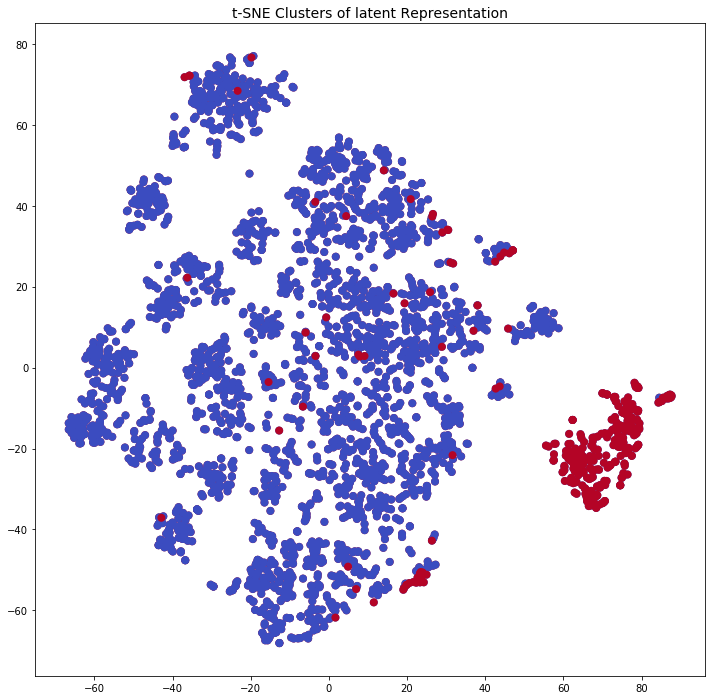

In [20]:
plot_cluster(rep_x, rep_y, title='t-SNE Clusters of latent Representation')

## Classification

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

### Logistic Regression

In [22]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25, random_state=42)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

### Logistic Regression Evaluation

In [23]:
print("Classification Report:\n")
print(classification_report(val_y, pred_y))

Classification Report:

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       755
         1.0       0.97      0.86      0.92        81

    accuracy                           0.98       836
   macro avg       0.98      0.93      0.95       836
weighted avg       0.98      0.98      0.98       836



In [24]:
# print(f"Confusion Matrix:")
# cm = confusion_matrix(val_y, pred_y, normalize='true')
# df_cm = pd.DataFrame(cm, index=['Normal', 'Fraud'], columns=['Normal', 'Fraud'])
# print(df_cm)

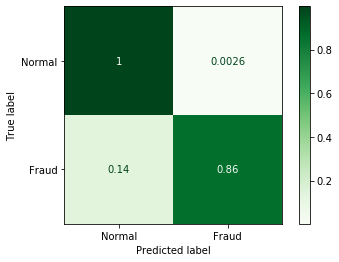

In [25]:
plot_confusion_matrix(clf, val_x, val_y, normalize='true', display_labels=['Normal', 'Fraud'], cmap='Greens')
plt.show()

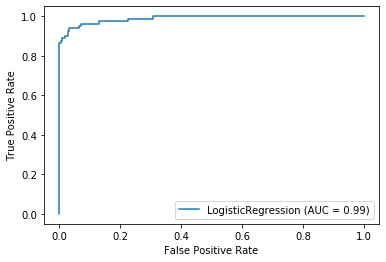

In [26]:
# try also with CV:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
plot_roc_curve(clf, val_x, val_y)
plt.show()

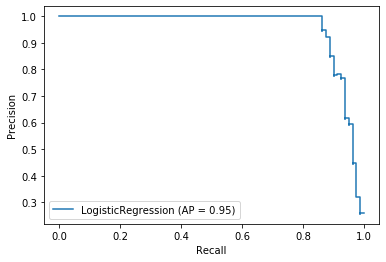

In [27]:
plot_precision_recall_curve(clf, val_x, val_y)
plt.show()

### Support Vector Machine

In [ ]:
from sklearn.svm import SVC

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25, random_state=42)
clf = SVC().fit(train_x, train_y)
pred_y = clf.predict(val_x)

### Support Vector Machine Evaluation

In [ ]:
print("Classification Report:\n")
print(classification_report(val_y, pred_y))

In [ ]:
plot_confusion_matrix(clf, val_x, val_y, normalize='true', display_labels=['Normal', 'Fraud'], cmap='ocean')
plt.show()

In [ ]:
plot_roc_curve(clf, val_x, val_y)
plt.show()

In [ ]:
plot_precision_recall_curve(clf, val_x, val_y)
plt.show()